In [1]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import ot
import gtda
import pymc as pm
import random

In [2]:
class block:
    def __init__(self, block):
        r = requests.get("http://127.0.0.1:8081/api/block/{}".format(block))
        data = json.loads(r.text)['data']
        
        for k,v in data.items():
            setattr(self, k, v)
            #print(type(i), type(j))
            #try:
            #    exec("self.{}={}".format(i,j))
            #except SyntaxError:
            #    exec("self.{}='{}'".format(i,j))
            
        self.sources = []
        self.sinks = []
        
                
    def get_txs(self):
        return [tx(i['tx_hash']) for i in self.txs]
                
                
    def __str__(self):
        return str(self.tx_hash)
    
    
                
        
class tx:
    def __init__(self, tx_hash):
        r = requests.get("http://127.0.0.1:8081/api/transaction/{}".format(tx_hash))
        data = json.loads(r.text)['data']
        for k,v in data.items():
            setattr(self, k, v)
        #self.tx_hash = tx_hash
        #self.coinbase = self.data['coinbase']
        if self.coinbase == False:
            self.get_rings()
        #elf.inputs = self.data['inputs']
            #mixins = [[j for j in i['mixins']] for i in self.dat['data']['inputs']]
            
        self.sources = []
        self.sinks = []
            
    def get_rings(self):
        self.rings = [ring(i) for i in self.inputs]

    def __str__(self):
        return str(self.tx_hash)
        
class ring:
    def __init__(self, inputs):
        self.mixins = [i['tx_hash'] for i in inputs['mixins']]
        self.block_no = [i['block_no'] for i in inputs['mixins']]
        self.youngest = self.block_no[-1]
        self.oldest = self.block_no[0]
        
        #self.sources = []
        self.sinks = []
        #self.tx_hash = tx_hash
        #self.coinbase = self.dat['data']['coinbase']
        
    def get_mixins(self):
        return [tx(i) for i in self.mixins]
    
    def get_distribution(self):
        n = len(self.mixins)
        self.probabilities = pymc.Categorical([1/n for i in range(n)])
        

        
    

In [3]:
def get_oldest_path(txo):
    
    mxn = txo.mixin
    while txo.coinbase==False:
        idx = np.argmin([i.oldest for i in txo.rings])
        txo = tx(txo.rings[idx].mixins[0])
        mxn = txo.mixin*mxn
        print(mxn)
        yield txo
        
def get_youngest_path(txo):
    mxn = txo.mixin
    while txo.coinbase==False:
        idx = np.argmax([i.youngest for i in txo.rings])
        txo = tx(txo.rings[idx].mixins[-1])
        yield txo

def get_random_paths(txo):
    
    while txo.coinbase==False:
        txo = tx(random.choice(random.choice(txo.rings).mixins))
        yield txo
    
    
    

In [4]:
def taint(txo, display=100, depth=1000000, maxtx = 5000000):
    current = 0
    coinbases = []
    if txo.coinbase == True:
        coinbases.append(txo.block_height)
        l = []
    else:
        l = [txo]
        
    yield l, coinbases
    
    cnt = 0
    loop = 0
    while len(l)>0 and cnt<maxtx:
        loop+=1
        print("loop", loop)
        l1 = []
        l2 = []
        for k in l:
            for j in k.rings:
                for h,i in zip(j.block_no,j.mixins):
                    if txo.block_height-h<depth:
                        txnew = tx(i)
                        if txnew.coinbase==True:
                            coinbases.append(txnew.block_height)
                        else:
                            l1.append(txnew)
                            cnt+=1
                            if cnt%display==0:
                                print(cnt)
                    else:
                        l2.append(i)
        yield l1, coinbases
        l = l1
    yield l2
        

In [5]:
def taint_ring(ring, depth=1000000, maxtx=5000000):
    ttrees_ring = [taint(i, depth=depth) for i in ring]
    
    while 1>0:
        yield [next(i) for i in ttrees_ring]

In [6]:
def cotxs(ttree1, ttree2):
    l21 = ttree1[-1]
    l22 = ttree2[-1]
    
    txs = []
    cbs = []
    for i,j in ttree[:-1]:
        txs+=i
        cbs+=j
    
    txs2 = []
    cbs2 = []
    for i,j in ttree2[:-1]:
        txs2+=i
        cbs2+=j
    
    txs_hashes = [i.tx_hash for i in txs]
    txs2_hashes = [i.tx_hash for i in txs2]
    
    return [i for i in set(txs_hashes) if i in txs2_hashes], [i for i in set(cbs) if i in cbs2], [i for i in l21 if i in l22]
    
    

In [18]:

num_blocks = 150
bs = [block(2800000+i) for i in range(num_blocks)]
bs_txs = [i.get_txs() for i in bs]

txo = bs_txs[-1][3]
txo2 = bs_txs[-1][4]
print(txo.rings[0].block_no)

[2782971, 2793886, 2795973, 2796873, 2797106, 2797481, 2797767, 2798021, 2798309, 2798585, 2799282, 2799732, 2799986, 2800128, 2800130, 2800133]


In [19]:
taint_txo = taint(txo, depth = 150)
taint_txo2 = taint(txo2, depth = 150)
ttree = [i for i in taint_txo]
ttree2 = [i for i in taint_txo2]
#print(txs), print(coinbases)

loop 1
loop 2
loop 3
loop 4
100
200
loop 5
300
400
loop 6
500
600
loop 7
700
loop 8
loop 9
loop 10
loop 1
loop 2
loop 3
100
loop 4
200
loop 5
loop 6
300
loop 7
400
loop 8
loop 9


In [20]:
txs = []
for i,j in ttree[:-1]:
    txs+=i
    
txs2 = []
for i,j in ttree2[:-1]:
    txs2+=i

In [21]:
len(txs), len(set([i.tx_hash for i in txs]))

(784, 414)

In [22]:
len(txs2), len(set([i.tx_hash for i in txs2]))

(415, 258)

In [31]:
tot_txs = []
for i in bs_txs:
    tot_txs+=i

In [23]:
a,b,c = cotxs(ttree, ttree2)

In [25]:
for i in [a,b,c]:
    print(len(i), len(set(i)))

178 178
2 2
16 16


In [30]:
a[0] in [i.tx_hash for i in txs2]

True

In [32]:
len(tot_txs)

2858

In [27]:
[i in txs for i in a]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [ ]:
txs_hashes = [i.tx_hash for i in txs]
txs2_hashes = [i.tx_hash for i in txs2]




In [56]:
[i.block_height for i in ttree[-1][0]]

[2799105,
 2799119,
 2799053,
 2799126,
 2799176,
 2799100,
 2799163,
 2799006,
 2799007,
 2799008,
 2799013,
 2799024,
 2799048,
 2799095,
 2799168,
 2799052,
 2799053,
 2799066,
 2799169,
 2799185,
 2799193,
 2799339,
 2799363,
 2799019,
 2799072,
 2799109,
 2799297,
 2799318,
 2799013,
 2799053,
 2799304,
 2799306,
 2799315,
 2799101,
 2799124,
 2799260,
 2799299,
 2799101,
 2799226,
 2799299,
 2799082,
 2799293,
 2799299,
 2799048,
 2799184,
 2799018,
 2799116,
 2799250,
 2799278,
 2799252,
 2799289,
 2799072,
 2799278,
 2799315,
 2799015,
 2799196,
 2799293,
 2799318,
 2799134,
 2799193,
 2799261,
 2799271,
 2799289,
 2799260,
 2799299,
 2799307,
 2799362,
 2799366,
 2799369,
 2799371,
 2799413,
 2799215,
 2799240,
 2799349,
 2799356,
 2799401,
 2799402,
 2799410,
 2799278,
 2799346,
 2799445,
 2799395,
 2799449,
 2799057,
 2799081,
 2799091,
 2799408,
 2799470,
 2799189,
 2799361,
 2799184,
 2799373,
 2799385,
 2799430,
 2799430,
 2799437,
 2799176,
 2799188,
 2799205,
 2799263,


In [60]:
len(set([i for i in ttree[-1][1]]))

286

In [40]:
for i in range(3):
    print(next(taint_txo))

([<__main__.tx object at 0x7f1dff030850>, <__main__.tx object at 0x7f1dfef343a0>, <__main__.tx object at 0x7f1dff4b1a80>, <__main__.tx object at 0x7f1dff4b1570>, <__main__.tx object at 0x7f1dff030550>, <__main__.tx object at 0x7f1dff0312d0>, <__main__.tx object at 0x7f1dff031450>, <__main__.tx object at 0x7f1dff030490>, <__main__.tx object at 0x7f1dff031390>, <__main__.tx object at 0x7f1dff030160>, <__main__.tx object at 0x7f1dff031510>, <__main__.tx object at 0x7f1dff031000>, <__main__.tx object at 0x7f1dff031750>, <__main__.tx object at 0x7f1dff031870>, <__main__.tx object at 0x7f1dff718190>, <__main__.tx object at 0x7f1e20c98400>], [])
100
200
300
400
([<__main__.tx object at 0x7f1e2097fbb0>, <__main__.tx object at 0x7f1dfef34ac0>, <__main__.tx object at 0x7f1dfef34970>, <__main__.tx object at 0x7f1dfef34ee0>, <__main__.tx object at 0x7f1dfef34250>, <__main__.tx object at 0x7f1dff4b1210>, <__main__.tx object at 0x7f1dff4b0b80>, <__main__.tx object at 0x7f1dff4b1420>, <__main__.tx ob

500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
([<__main__.tx object at 0x7f1e1f2a43d0>, <__main__.tx object at 0x7f1dff719ff0>, <__main__.tx object at 0x7f1dff4b1a20>, <__main__.tx object at 0x7f1dfef343a0>, <__main__.tx object at 0x7f1dfef34d00>, <__main__.tx object at 0x7f1e1fd57cd0>, <__main__.tx object at 0x7f1dfef34e50>, <__main__.tx object at 0x7f1e2097fdf0>, <__main__.tx object at 0x7f1dff030c10>, <__main__.tx object at 0x7f1dff030850>, <__main__.tx object at 0x7f1dff031660>, <__main__.tx object at 0x7f1dff031600>, <__main__.tx object at 0

In [7]:
for j,i in enumerate(get_oldest_path(txo)):
    print(j+1, i, i.block_height, i.xmr_outputs)

176
1 dc7faa23d6251278ae4a6777332703f52e3af2d4557f9bb68c1a9fce84b93984 2574235 0
1936
2 fe0715084027a33e65534cb802593d9bc9b678b364c7f2a1e89b258ede66deab 2467242 0
21296
3 b9b515f6adc5e4ef94c507e8c18da97541c512d0295aa9b448497c1e0ee8b58b 2348878 0
234256
4 746047fb5b6543201d8a3e61c14b91dcf27419effa04e85ce50d45b3a2249320 2135085 0
2576816
5 7b49f881114cad24aa61976929b8b85f232c3216da43985c4ffee0328b469b27 2117835 0
0
6 f1a2b60ee65d55384128efb8730061712f415c994a4cee577987f83ff4aef884 2104371 1671891333320


In [13]:
for i in get_random_paths(txo):
    print(i, i.block_height, i.xmr_outputs)

9cbe92b3897a1b6a57146e24342d443502ab54062bf596f9910a1e54d435625e 2796793 0
3b3e73c452e1120b178a5ec0a9e84f48fd51449f97be6155e6051b4b63bfe449 2696332 0
af7def674635f88278d2de04c86e65d49787c6264c4a3bfc9739e1d3105aeb2b 2591623 0
b5c98f26e2615463a995c2a02f910fbf9df14f74a156f8640b29d6374118b6a5 2568867 0
2ed8839e619a7ab8111d616c62d100d9f39ec58b1fad8e7cc2b1cb8fcf98fb6e 2568847 0
f6167ca061238030abfb709f14064b4af9afa39add5cc4ed053440c9edead7e5 2559417 0
f531542f1284cc7c866afbd31348c7aae7ed369e84deadba9c551dc893b2f1d2 2559398 0
18b8c52862e6ab094dcbb42ff7ed788320b9dfbc96a1b85212ff506005a1c8fd 2551651 0
9f8e703557c2c38f83d551ea27d642ac53bd88aeb226507858275b08ad03468f 2551641 0
da887d12fc186b761aa53b9e9f87b66840d00b3888fdcf861c0ddf459216cb97 2548196 0
c680ddd557baaa252c910dc6d064b1bbfffcf549fbb7e10eef3f046eee2ce554 2521349 0
232317b472d1389d6c3d96d9601649b75cfa5f8af1064e3205d24a7b509b089f 2521244 0
c183d7ca600359a2dd5a384a4741680b2a4674e25b1401fdb8e893c8b149f364 2520531 0
035e661b5f0d49afeab07f765

In [28]:
taint_txo = taint(txo)

In [25]:
for i in range(5):
    l, coinbases = next(taint_txo)

StopIteration: 

In [ ]:
mixins = []
block_no = []
for i in bs_txs:
    for j in i:
        if j.coinbase==False:
            for k in j.rings:
                mixins+=k.mixins
                block_no+=[l/j.block_height for l in k.block_no]

In [7]:
mixins = []
block_no = []
for i in bs_txs:
    for j in i:
        if j.coinbase==False:
            for k in j.rings:
                mixins+=k.mixins
                block_no+=[l/j.block_height for l in k.block_no]
                

Text(0.5, 1.0, 'Distribution of Decoy + Real Txs')

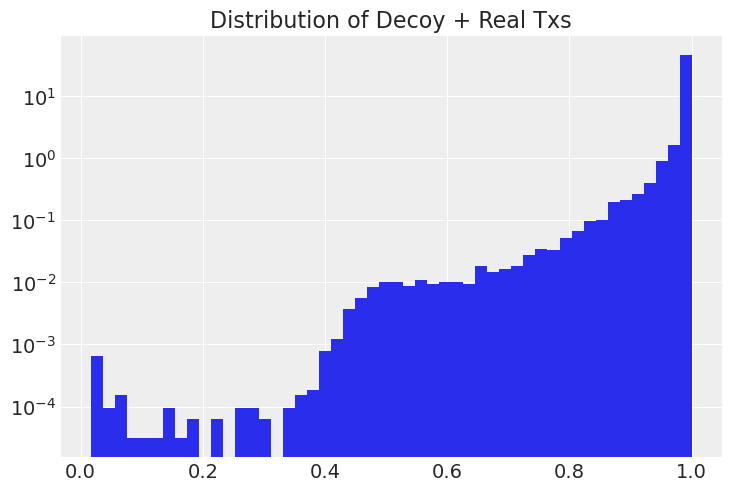

In [22]:
plt.hist(block_no, bins = 50, log=True, density=True);
plt.title("Distribution of Decoy + Real Txs")

In [12]:
len(block_no)

1635776

In [145]:
n2500000 = block(2500000)

In [146]:
n2500000.txs

[{'coinbase': True,
  'extra': '0177618f8c5267ce07df543d4ec7afeedc24838ff349a4573c59464377e8ec5fc5020800bce8ff52fdfc00',
  'mixin': 0,
  'payment_id': '',
  'payment_id8': '',
  'rct_type': 0,
  'tx_fee': 0,
  'tx_hash': '30645f57ad32f1c4f40f3dc2faff0d56cae8ac5ac446ed88f6058d5b3a4a1d76',
  'tx_size': 96,
  'tx_version': 2,
  'xmr_inputs': 0,
  'xmr_outputs': 786438955421},
 {'coinbase': False,
  'extra': '01eaaa5acba0bc44657da783903d3de7febf7124ae03cf578938244068b475d906020901da0190b93466979e',
  'mixin': 11,
  'payment_id': '',
  'payment_id8': 'da0190b93466979e',
  'rct_type': 5,
  'tx_fee': 7600000,
  'tx_hash': 'c39652b79beb888464525fee06c3d078463af5b76d493785f8903cae93405603',
  'tx_size': 1449,
  'tx_version': 2,
  'xmr_inputs': 0,
  'xmr_outputs': 0},
 {'coinbase': False,
  'extra': '01addc159a157cfe93b7969488df3df4e4cc0681567eb23fbf9bb47e148a2b9058020901b46c5e4d7d91f276',
  'mixin': 11,
  'payment_id': '',
  'payment_id8': 'b46c5e4d7d91f276',
  'rct_type': 5,
  'tx_fee': 761000

In [147]:
txs = n2500000.get_txs()

In [153]:
txo = txs[1]
for i in get_oldest_path(txo):
    print(i, i.block_height, i.coinbase)

28b67861c9080cb22152b635d9675e57365b9d17dc9defe96e5177acc3fa5e48 2495960 False
ab59943b73b5d011545b2ddd256963109e6b081c746616dbd60389950493e205 2463568 False
7f5c4b11f94d8640c57832b0f1e5ee70cc15ddf6d9d41bc08db152dc63ade923 2217551 False
3c4ca9a229b09d8bbcd5cda7871ab7d6b2f1cd919350b4149fe20bff55013f9c 2173943 False
a6c80ec4ddbd6323ff247da2c8f233ee1fa1942ae1badc927a50a24406d10375 2145854 False
9ac828df6436b2509550ef01a746dabdcdaa85b14c155bfcf39100fd9d3f6ab1 1835538 False
2f10f9fe93a7bf2678f0ef28251c05bbc5204f4251aa6ea2d1635ae2223e83c1 1827936 False
c0c7de65e840556c1baf1b2d471e152beb2d729e2fe46c0aa80ba050991216ee 1818301 True


In [156]:
i.xmr_outputs

2886912931864

In [129]:
txo.rings[0].block_no

[2495960,
 2499133,
 2499253,
 2499315,
 2499390,
 2499735,
 2499842,
 2499941,
 2499955,
 2499967,
 2499967]

(array([2.70000e+01, 4.00000e+00, 4.00000e+00, 3.00000e+00, 4.00000e+00,
        5.00000e+00, 4.00000e+00, 3.20000e+01, 2.10000e+02, 6.48000e+02,
        7.52000e+02, 8.32000e+02, 7.80000e+02, 1.31300e+03, 1.78500e+03,
        3.03500e+03, 6.24900e+03, 1.29430e+04, 2.47600e+04, 1.56784e+05]),
 array([0.01695145, 0.06560388, 0.11425631, 0.16290873, 0.21156116,
        0.26021359, 0.30886602, 0.35751844, 0.40617087, 0.4548233 ,
        0.50347572, 0.55212815, 0.60078058, 0.64943301, 0.69808543,
        0.74673786, 0.79539029, 0.84404271, 0.89269514, 0.94134757,
        0.99      ]),
 <BarContainer object of 20 artists>)

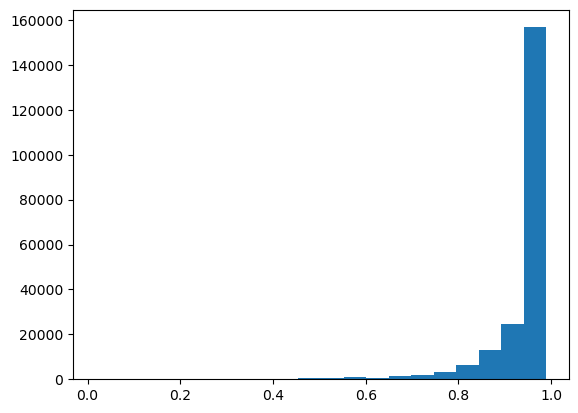

In [24]:
plt.hist(block_no[block_no<.99], bins=20)

In [176]:
len(block_no[block_no>.999642]), len(block_no)

(3634948, 7767920)

In [102]:
a,b = np.unique(mixins, return_counts=True)

In [38]:
with pm.Model() as model:
    alpha = pm.Uniform("alpha", lower=0,upper=50)
    beta = pm.Uniform("beta", lower=0, upper = 10)

with model:
    observation = pm.Beta("decoy", alpha, beta, observed=block_no)
    sdecoy = pm.Beta("sdecoy", 19.38, 1/61)
    sdecoy2 = pm.Beta("sdecoy2", 28.05, .249)
    #decoy = pm.Beta('decoy', 19.38, 1/61)

In [39]:

with model:
    step = pm.Metropolis()
    trace2 = pm.sample(3000, tune=500, step=step, return_inferencedata=False)



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sdecoy]
>Metropolis: [sdecoy2]


/home/zqdizzah/.anaconda3/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/zqdizzah/.anaconda3/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/zqdizzah/.anaconda3/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/zqdizzah/.anaconda3/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 500 tune and 3_000 draw iterations (2_000 + 12_000 draws total) took 157 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for de

In [112]:
pm.sample?

In [111]:
trace2.varnames

['alpha_interval__',
 'beta_interval__',
 'sdecoy_logodds__',
 'sdecoy2_logodds__',
 'alpha',
 'beta',
 'sdecoy',
 'sdecoy2']

Text(0.5, 1.0, 'Fits of the Alpha parameter')

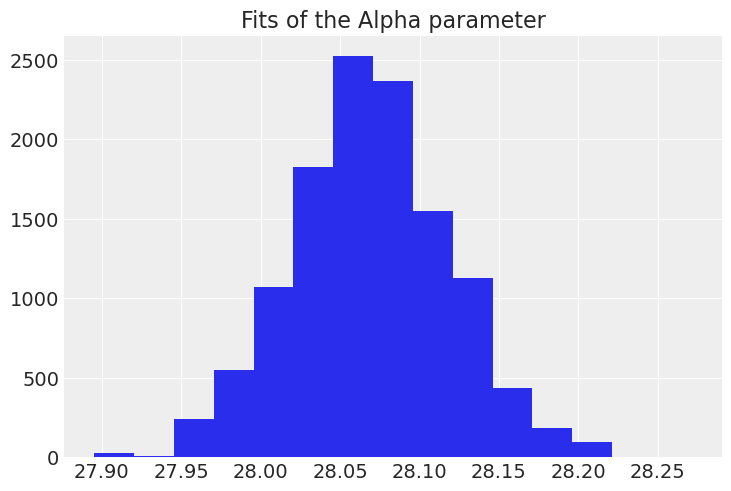

In [40]:
plt.hist(trace2['alpha'], bins=15)
plt.title('Fits of the Alpha parameter')

Text(0.5, 1.0, 'Fits of the Beta parameter')

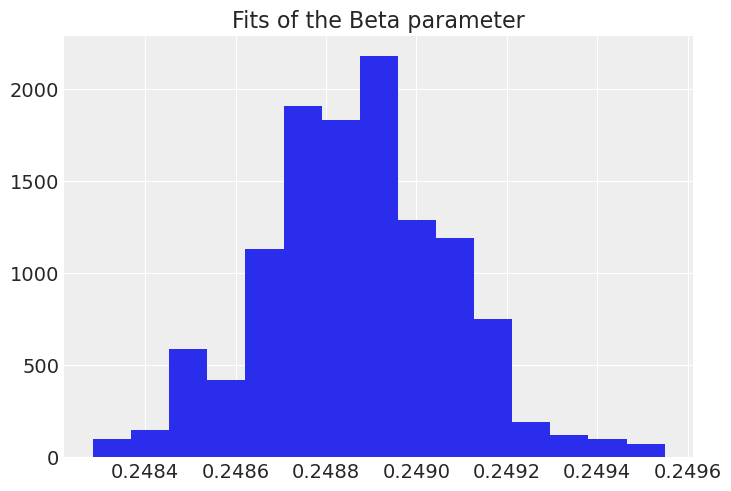

In [41]:
plt.hist(trace2['beta'], bins=15)
plt.title('Fits of the Beta parameter')

Text(0.5, 1.0, 'Random Draws from Fit (blue) and Expected (orange)')

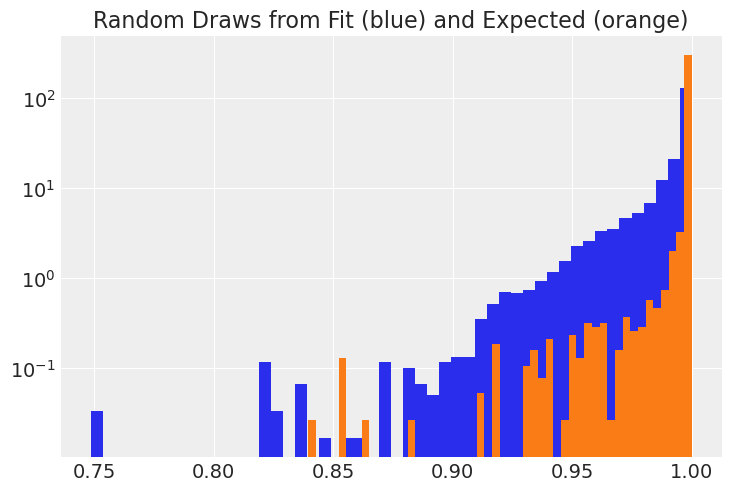

In [43]:
plt.hist(trace2["sdecoy2"], bins = 50, density=True, log=True)
plt.hist(trace2["sdecoy"], bins = 50, density=True, log=True);
plt.title("Random Draws from Fit (blue) and Expected (orange)")

Text(0.5, 1.0, 'Distribution of Decoy + Real Txs')

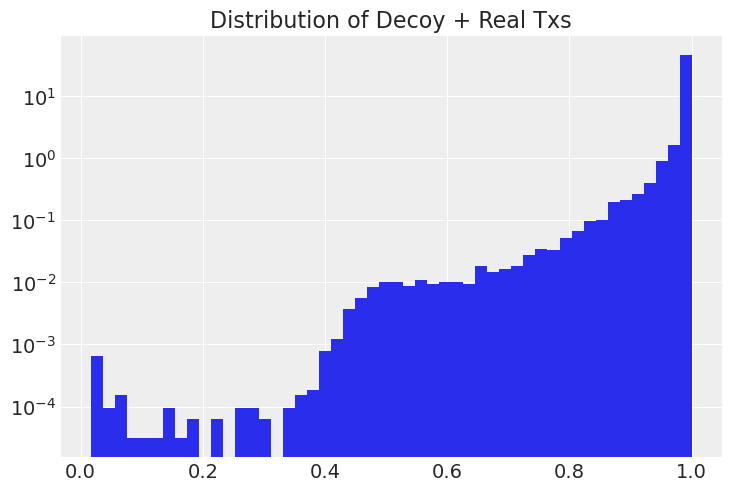

In [26]:
plt.hist(block_no, bins = 50, log=True, density=True);
plt.title("Distribution of Decoy + Real Txs")

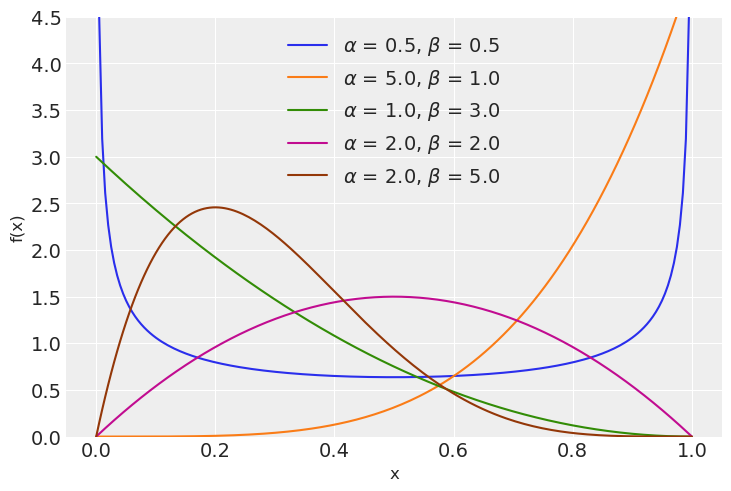

In [124]:

import scipy.stats as st
import arviz as az
plt.style.use('arviz-darkgrid')
x = np.linspace(0, 1, 200)
alphas = [.5, 5., 1., 2., 2.]
betas = [.5, 1., 3., 2., 5.]
for a, b in zip(alphas, betas):
    pdf = st.beta.pdf(x, a, b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

AttributeError: module 'pymc' has no attribute 'MCMC'

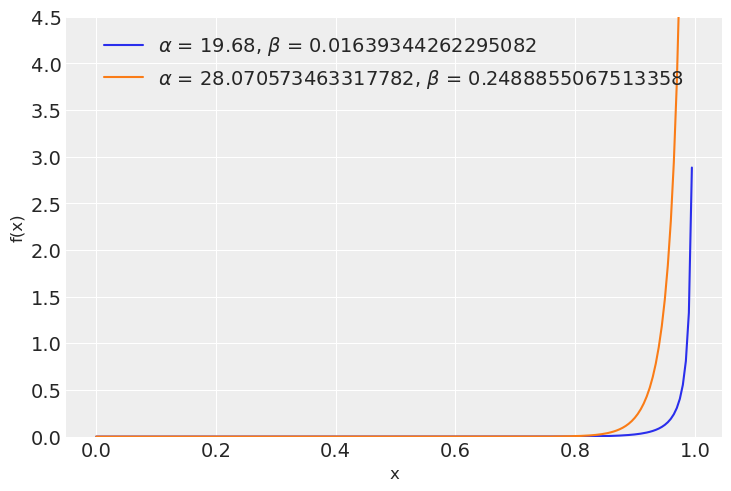

In [32]:

import scipy.stats as st
import arviz as az
plt.style.use('arviz-darkgrid')
x = np.linspace(0, 1, 200)
alphas = [19.68, trace2['alpha'].mean()]
betas = [1/61,trace2['beta'].mean()]
for a, b in zip(alphas, betas):
    pdf = st.beta.pdf(x, a, b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

In [131]:
import random
import numpy as np
import pymc as pm
#from pymc import Normal, Uniform
#from pymc import MCMC
import math



In [136]:
trials = 160
successes = 150

with pm.Model() as coin_flip_model:
    p = pm.Beta("p", alpha=19.38, beta=1/61)
    obs = pm.Binomial("obs", p=p, n=trials, observed=successes)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


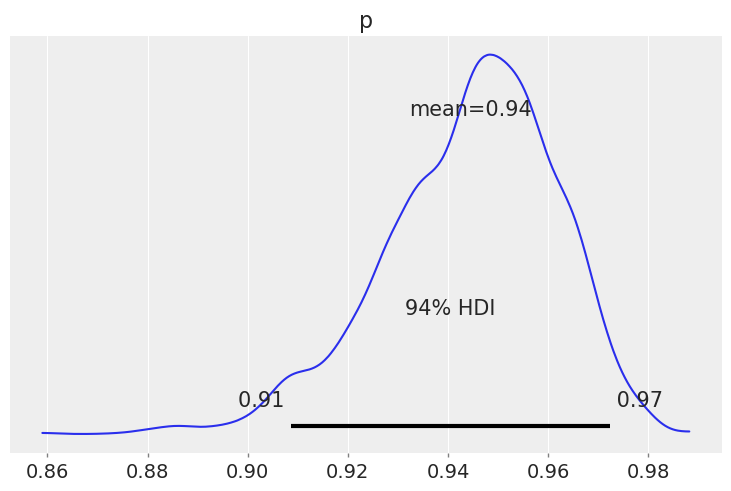

<Axes: title={'center': 'p'}>

In [137]:
import arviz as az
az.plot_posterior(idata, show=True)

In [46]:
cnt = 0
ts = []
while len(ts)<2:
    b1 = block(800000+cnt)
    ts = [tx(i['tx_hash']) for i in b1.txs]
    cnt+=1
    print(cnt, len(ts))

1 1
2 3


In [47]:
b1.txs[1]

{'coinbase': False,
 'extra': '01a0b1c1c884890e7b358ecb96c1ac227df858d9663dd3e84b0b183657ceb08815',
 'mixin': 1,
 'payment_id': '',
 'payment_id8': '',
 'rct_type': 0,
 'tx_fee': 10000000000,
 'tx_hash': '0897e387fecb458a0deca6c5c9381f1766c1105bc50d8f5bb3d7894d2256b7b7',
 'tx_size': 450,
 'tx_version': 1,
 'xmr_inputs': 100010000000000,
 'xmr_outputs': 100000000000000}

In [48]:
#b1 = block(1100000)
#ts = [tx(i['tx_hash']) for i in b1.txs]
ttxo = taint(ts[1], display=1500)

In [52]:
for i in get_oldest_path(ts[1]):
    print(i)

AttributeError: 'tx' object has no attribute 'mixins'

In [50]:
tx('d674680e600ffc628fff0e643819d0f550e5d44d798ea6f7d6925dd871f3f38f').coinbase

False

In [51]:
%%time
for i,j in enumerate(ttxo):
    print(j[1])
    print(len(j[0]), len(j[1]))

[]
1 0
[]
0 0
CPU times: user 1.79 ms, sys: 3.71 ms, total: 5.5 ms
Wall time: 89 ms


In [10]:
j[0]

[]

In [24]:
ts[1].inputs

[{'amount': 664640,
  'key_image': 'b49dbba6e8aacdb65e0db6d9362ab0b592c265d95eb3b0dd64e3e0242517c562',
  'mixins': [{'block_no': 9851,
    'public_key': 'ea52eb04bcef4ba1a82bcff0d983ff288e5788bfb59719ec9055d89427cb2c76',
    'tx_hash': 'f762733ce93bf5c3744424bdfba1dbe0269899836cfd6daa8751ebe789f83a60'}]},
 {'amount': 400000000000,
  'key_image': 'f53b755f0cdc0acb7a3f640e76843f22c5824b66c380168e393eb46d82ed66c1',
  'mixins': [{'block_no': 9851,
    'public_key': '938048d5e9a0324ab62146da87b8f3eb3a0bc35f3f37fd9e25c1849d6347baae',
    'tx_hash': 'f762733ce93bf5c3744424bdfba1dbe0269899836cfd6daa8751ebe789f83a60'}]},
 {'amount': 7000000000,
  'key_image': 'f69a277c13eeaedb8f21a6b89ca34c10b77eeeb7842b79817f67fdc87859c6fa',
  'mixins': [{'block_no': 9851,
    'public_key': '71ac84349f42096efda3afcec7107fe0771630a566f9facf5251b3caa8d60314',
    'tx_hash': 'f762733ce93bf5c3744424bdfba1dbe0269899836cfd6daa8751ebe789f83a60'}]},
 {'amount': 10000000000000,
  'key_image': '763dae738cb6edfac83918dc4

In [370]:
[i.block_height for i in ls[-1][0]]

[2228166,
 2241432,
 2247822,
 2254221,
 2254228,
 2255209,
 2255470,
 2255500,
 2255560,
 2255564,
 2255569,
 2256825,
 2268860,
 2269645,
 2270829,
 2270840,
 2272252,
 2273186,
 2273414,
 2273604,
 2273633,
 2273638,
 2239569,
 2264182,
 2269015,
 2269923,
 2270914,
 2273019,
 2273164,
 2273545,
 2273596,
 2273639,
 2205005,
 2247429,
 2256859,
 2266987,
 2269132,
 2269337,
 2273479,
 2273576,
 2273587,
 2273612,
 2273635,
 2259803,
 2266393,
 2267461,
 2271942,
 2272180,
 2273181,
 2273366,
 2273443,
 2273562,
 2273565,
 2273638,
 1832516,
 2142997,
 2254513,
 2267832,
 2271996,
 2272682,
 2273076,
 2273362,
 2273412,
 2273521,
 2273638,
 2231155,
 2267358,
 2272126,
 2272928,
 2273379,
 2273440,
 2273531,
 2273544,
 2273604,
 2273625,
 2273626,
 2267346,
 2269175,
 2270982,
 2271097,
 2271529,
 2272322,
 2273466,
 2273626,
 2273630,
 2273633,
 2273638,
 1866704,
 2256368,
 2258437,
 2266045,
 2272614,
 2273034,
 2273054,
 2273156,
 2273594,
 2273626,
 2273633,
 2226365,
 2247827,


In [ ]:
%%time 
ls.append(next(ttxo))

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150
1

70150
70200
70250
70300
70350
70400
70450
70500
70550
70600
70650
70700
70750
70800
70850
70900
70950
71000
71050
71100
71150
71200
71250
71300
71350
71400
71450
71500
71550
71600
71650
71700
71750
71800
71850
71900
71950
72000
72050
72100
72150
72200
72250
72300
72350
72400
72450
72500
72550
72600
72650
72700
72750
72800
72850
72900
72950
73000
73050
73100
73150
73200
73250
73300
73350
73400
73450
73500
73550
73600
73650
73700
73750
73800
73850
73900
73950
74000
74050
74100
74150
74200
74250
74300
74350
74400
74450
74500
74550
74600
74650
74700
74750
74800
74850
74900
74950
75000
75050
75100
75150
75200
75250
75300
75350
75400
75450
75500
75550
75600
75650
75700
75750
75800
75850
75900
75950
76000
76050
76100
76150
76200
76250
76300
76350
76400
76450
76500
76550
76600
76650
76700
76750
76800
76850
76900
76950
77000
77050
77100
77150
77200
77250
77300
77350
77400
77450
77500
77550
77600
77650
77700
77750
77800
77850
77900
77950
78000
78050
78100
78150
78200
78250
78300
78350
78400
7845

133000
133050
133100
133150
133200
133250
133300
133350
133400
133450
133500
133550
133600
133650
133700
133750
133800
133850
133900
133950
134000
134050
134100
134150
134200
134250
134300
134350
134400
134450
134500
134550
134600
134650
134700
134750
134800
134850
134900
134950
135000
135050
135100
135150
135200
135250
135300
135350
135400
135450
135500
135550
135600
135650
135700
135750
135800
135850
135900
135950
136000
136050
136100
136150
136200
136250
136300
136350
136400
136450
136500
136550
136600
136650
136700
136750
136800
136850
136900
136950
137000
137050
137100
137150
137200
137250
137300
137350
137400
137450
137500
137550
137600
137650
137700
137750
137800
137850
137900
137950
138000
138050
138100
138150
138200
138250
138300
138350
138400
138450
138500
138550
138600
138650
138700
138750
138800
138850
138900
138950
139000
139050
139100
139150
139200
139250
139300
139350
139400
139450
139500
139550
139600
139650
139700
139750
139800
139850
139900
139950
140000
140050
140100

191550
191600
191650
191700
191750
191800
191850
191900
191950
192000
192050
192100
192150
192200
192250
192300
192350
192400
192450
192500
192550
192600
192650
192700
192750
192800
192850
192900
192950
193000
193050
193100
193150
193200
193250
193300
193350
193400
193450
193500
193550
193600
193650
193700
193750
193800
193850
193900
193950
194000
194050
194100
194150
194200
194250
194300
194350
194400
194450
194500
194550
194600
194650
194700
194750
194800
194850
194900
194950
195000
195050
195100
195150
195200
195250
195300
195350
195400
195450
195500
195550
195600
195650
195700
195750
195800
195850
195900
195950
196000
196050
196100
196150
196200
196250
196300
196350
196400
196450
196500
196550
196600
196650
196700
196750
196800
196850
196900
196950
197000
197050
197100
197150
197200
197250
197300
197350
197400
197450
197500
197550
197600
197650
197700
197750
197800
197850
197900
197950
198000
198050
198100
198150
198200
198250
198300
198350
198400
198450
198500
198550
198600
198650

In [322]:
l1, coinbases1 = next(ttxo)
print(l1, coinbases1)

[<__main__.tx object at 0x7fbe30a042e0>, <__main__.tx object at 0x7fbe322f7100>, <__main__.tx object at 0x7fbe3391c700>, <__main__.tx object at 0x7fbe3391d9c0>, <__main__.tx object at 0x7fbe30a05600>, <__main__.tx object at 0x7fbe30a041c0>, <__main__.tx object at 0x7fbe30a04f70>, <__main__.tx object at 0x7fbe30a04c10>, <__main__.tx object at 0x7fbe30a05180>, <__main__.tx object at 0x7fbe30a056c0>, <__main__.tx object at 0x7fbe30a05cc0>, <__main__.tx object at 0x7fbe30a05ae0>, <__main__.tx object at 0x7fbe30a05510>, <__main__.tx object at 0x7fbe30a05c60>, <__main__.tx object at 0x7fbe30a052a0>, <__main__.tx object at 0x7fbe30a06050>, <__main__.tx object at 0x7fbe30a063b0>, <__main__.tx object at 0x7fbe30a06110>, <__main__.tx object at 0x7fbe30a063e0>, <__main__.tx object at 0x7fbe30a05db0>, <__main__.tx object at 0x7fbe30a068f0>, <__main__.tx object at 0x7fbe30a067d0>, <__main__.tx object at 0x7fbe30a06740>, <__main__.tx object at 0x7fbe30a05d20>, <__main__.tx object at 0x7fbe30a05b40>,

In [324]:
l2, coinbases2 = next(ttxo)
print(len(l2), (coinbases2))

KeyboardInterrupt: 

In [311]:
for i in [l0,l1,l2]:
    print(i)

[<__main__.tx object at 0x7fbe31fb1690>, <__main__.tx object at 0x7fbe322f9de0>, <__main__.tx object at 0x7fbe322fa200>, <__main__.tx object at 0x7fbe31fb23b0>, <__main__.tx object at 0x7fbe31fb28c0>, <__main__.tx object at 0x7fbe31fb1a50>, <__main__.tx object at 0x7fbe31fb2380>, <__main__.tx object at 0x7fbe31fb3010>, <__main__.tx object at 0x7fbe31fb1900>, <__main__.tx object at 0x7fbe31fb27d0>, <__main__.tx object at 0x7fbe31fb1cc0>, <__main__.tx object at 0x7fbe31fb2e60>, <__main__.tx object at 0x7fbe31fb3b50>, <__main__.tx object at 0x7fbe31fb2590>, <__main__.tx object at 0x7fbe31fb3940>, <__main__.tx object at 0x7fbe31fb2290>, <__main__.tx object at 0x7fbe31fb2c50>, <__main__.tx object at 0x7fbe31fb3d60>, <__main__.tx object at 0x7fbe31fb36d0>, <__main__.tx object at 0x7fbe31fb3190>, <__main__.tx object at 0x7fbe31fb3130>, <__main__.tx object at 0x7fbe31fb2230>, <__main__.tx object at 0x7fbe31fb3340>, <__main__.tx object at 0x7fbe31fb17e0>, <__main__.tx object at 0x7fbe31fb3550>,

In [317]:
len(coinbases2)

59

In [287]:
l2 = []
coinbases = []
for k in l1:
    if k.coinbase==True:
        coinbases.append(k)
        continue
    
    for j in k.rings:
        for i in j.mixins:
            l2.append(tx(i))

In [290]:
coinbases

[<__main__.tx at 0x7fbe3855bfd0>, <__main__.tx at 0x7fbe385587f0>]

In [271]:
taint_tree[1][0][15].rings[0].mixins

['e7975c62557ce695a559e5298234a0601645614ac76a9aa05b1df80e19ec5077',
 'dd69dd457679f45760fff19b236e54d237f7e81599430076986ad2fb17916341',
 'b5edec2e31a898bd21e1eed894ee75ad61b8b65131e6b935e797564976ca193a',
 'bc01e2183a6e724c1304f81c0141f99de9280582bdd4f68f172450769efbccbe',
 '056ed06a17c93b8f2c2016857fecbb23d61c893fe841085a3546be62b3b18324',
 '1b6a5399cf98c3e016d8a5078d2ac26d57cf8741eca233cd9ed5c7976d4e9f5b',
 'd4a867c5233cf4bf1e7ecae1b3032f2d21ba41fd82f9b8d81178a853c86fe88a',
 'cf0a9a46c5c9802f5d5218b6d8e31b0ee5435233e25fdc6c2033f93865c367a5',
 'f7552770be006812904cdf704f7227c5713d387e4b02e5b2b783a100149421d0',
 'f0d0c00c119ba5368103a2aa39058f5d1010cc98ab7caee050275adb835d0add',
 'a26b0e644d89106edaf11f655c56b724d631cebcac5b27f06e1b57882516ee16',
 'b90d3a3c312360370992034ffb8c2506aacf5263503772adba7c2e77b7c27a08',
 '1da06939400447a943549d67dcec77e843a83cf2a4a5a2e78a5fae416b9a28d2',
 '8f5ba4c34e63d4a1e212622d301eef2f4e683a1684d53a0a58cd3900ed1555e8',
 'dad7607426d53179b8dc5df74a67f487

In [ ]:
class taint():
    def __init__(self, txo):
        self.current = 0
        self.coinbase = []
        
        for ring in txo.rings:
            for mixin in ring.mixins:
                print(mixin.tx_hash)
            
    def simplex(self):
            
        

In [256]:
i.tx_hash for i in taint_tree[1]

[[<__main__.tx at 0x7fbe3a06ccd0>,

In [254]:
taint_tree[0][0].rings[0].mixins

['7cd45421f5d154b2034dee599dba3cc6603d7f3b990e6421341dbaffbf9d80e9',
 '7b2309ed380821857a674c8a9f5c0feb4fc3a93afb2c2e795b801edd3f125660',
 '20da757c4a4a606c3f24c9d125cf2c23124fbf3ba7e958647ec3810e3ed3884c',
 '90f4517f997eb1fef119e6a824946cc03e452df2d26b837c77db2a40f816c799',
 'd1fc38bc6e1a3fe0d5c63f4b4683d6e7e75be190c5353ccc28eb80afd0a6f57d',
 '071395b5de30044687c8590e8c91e3c447b33f51bcadffa9f1be85c9cc94f979',
 '8712f193bb7d21253caed972ad9d4803aa8033bd6061cd8d1353ed8e616248df',
 'fa188b1283ce87e7f49e0c60f3cc0211481cc2d86b163d877c282dec333bf91b',
 '94f472a2a9bb30f89708369144859d8315cf2cce6312e45fa36b110cd7531178',
 '569ce025ff61deb40194e21f1fbb3d8c33f0eb5fe39091d64ddb5252e70e4e19',
 'ec91d513f034a72c6facf8f4dfca18366dec67e23b5fe6d7179833b28b8ebf12',
 '8176110aa7916ad7d57323276169a7ad9ee4e6482ecca0b217b81ae5597e3b31',
 'be11209f35b7e33fd7aa5eb1481d105c8b4fcb65522bb3d96c3372f05da11d87',
 '3ab502c87de0524931c6b6372566007cc912153a70999e0776ed7b00b151f181',
 '2cbd3c76488284a67ecd1a99dde2c10f

In [4]:
b1 = block(1900000)
ts = [tx(i['tx_hash']) for i in b1.txs]

In [207]:
for i in ts[4].rings[1].mixins:
    print(i)

35b707bb55c951f0c36a72d3721ed6738058c4ee9288b9faa0b9a84a14469aab
4d199253f08a02d35777bb7396a9a48dc2a5448db0feb8b9af229a18e2bdc0b2
9d0694bb6455ce5b6d643bcff7ca094665877628b53df1e93bcf9eece69fd3d1
7c5826ba66d8903b0ee668df119ff63acfd1e8cff1eaf0d94852f90b0023fd14
d3fdfcd28de7da8249957a8e0396924b55dc7eff0758f2f94854dcd3e768f00c
08929ec4e821c4bc461439f00ef0d0cc73173f3afe3f75170a9408fd2f1a2d84
f9e7a498b1f389af9851910d02394662b4cba93092de08ddd14287b004c25d20
d67b022b8497844f6acd464b814859e8159e0792aaf6c2b98f52d7311ed6650e
e82ae8843e58f3ac83b7f27e36b587ed8ed952c80f1426425400728eb94f01d1
ec53e03bf585874071db800bb990c4bb79b2dd42b3b105248389d2675d46bdad
825614d0af3d8141dd4b712474783e12be0032e66ccfefd3d5c5732b88fbcc3e
07424016cb5c155cf39dd6117d0145c063efb58ea08ad6b98495b64df10c0db0
b703738a3822d30a065944878a86d6faba89d1a16d1635a85699d1e61c60e3c6
447ddb4e1ba9c84cb8959e02231a13c60fae4b4b5abd42e669c9cac4dcc7390f
8508ef58d5ea25c60c754231eec3899a610c4668721aafdf9ef73973e33a9405
4dc6756bb267b6860edc80eb9

In [7]:
len(b1.txs)

17

In [196]:
ts[4].rings[0].mixins[0].inputs

[{'amount': 0,
  'key_image': 'a8b3b3e27acc54b6331e4d46ac23efe1000574820612b7ac1ee66aba90d1eaf8',
  'mixins': [{'block_no': 2255586,
    'public_key': '47a1a3f75e186b6958dfe633674d3e9f8b3b617a4e21f8951478221ed56adc46',
    'tx_hash': 'c5d360cc3ae6b948250bb6f65a5ef90ad1bc34680a1d96eea99ee6ba2e2c5015'},
   {'block_no': 2273650,
    'public_key': '4d8655eff962c1650fda25a14475859bc354d64ecd065ac13a35238e16e948f1',
    'tx_hash': '620fb2f37661d5b29801d2e1da2d66039e6149441c2cf12e44d0baad3b67c656'},
   {'block_no': 2278248,
    'public_key': 'e004f8516c4d651fab5a8fb9f6756b71ab50111f91ebc2c64cd9fced8f4ed786',
    'tx_hash': '658c4a6fb3be3b4f162423fd7a6e4eaa72955cf9b27e972e05c5fbbdb91a98d5'},
   {'block_no': 2282477,
    'public_key': '7f864bf5c5353af2f4101a42b1d24636e9193696174a91d46cbeb1475db6744c',
    'tx_hash': '1732b1b7d55091ba4f98954122bf6b9390f3d82e9e000dc1ba14a3d47a81af62'},
   {'block_no': 2283051,
    'public_key': '0bba83ab0206d68101edd790401e01f0d7b5ef503dcc52c1e5f64e1b917a42dd',
 

In [8]:
ts[4].inputs

[{'amount': 0,
  'key_image': '4337a6120de103e49850fabf334b42535d2f8978dc299ee564878875078cda49',
  'mixins': [{'block_no': 1429154,
    'public_key': 'fd5b66014640d6ae2b01635a7a19b880ec5145267269b31a750da7307d5dd806',
    'tx_hash': '0259107c09e57ae2dd0703495c083da6bd4cab5082e0637a4845006bed0ed263'},
   {'block_no': 1601399,
    'public_key': '4340df337b8863c661bdf31def3f7e7022415e410bafe05ebe3047f0451e362e',
    'tx_hash': '3087109d369a1e74af116d1d4f46ae4600589f4806995706c28a7409bc469566'},
   {'block_no': 1678421,
    'public_key': '226daf927f46545cdd1a06964e69ae20cf929645c269afeb44622542bcd9e1fd',
    'tx_hash': '3da225cd90fc3d6bdff77f0f77099c021366b4f7fe66f1b59ad045a01795c221'},
   {'block_no': 1691531,
    'public_key': 'c32bf666ffb6bbe39bfdd09291290de90a7a043207659475998fc24b735699a2',
    'tx_hash': 'd888e954b064875ec3e393d8124dadc8ab68e11bcaafdc81652eb8c566251cca'},
   {'block_no': 1850873,
    'public_key': '68f3718ba884283934e3676bd8735c1b17da5729c3bda3571705a6e032f4f6c5',
 

In [135]:
b1.txs[1]

{'coinbase': False,
 'extra': '011a37d4e7618a165a9accc4bfeb58c5c9ad08a8520f40bb6fd5e7aad11d8e6dd6020901ea5ca4c9ed98bf46',
 'mixin': 16,
 'payment_id': '',
 'payment_id8': 'ea5ca4c9ed98bf46',
 'rct_type': 6,
 'tx_fee': 158600000,
 'tx_hash': '1164e07ebadb8916f964e32b28d46045dea15905f2387cc6119bfc06466186f5',
 'tx_size': 1529,
 'tx_version': 2,
 'xmr_inputs': 0,
 'xmr_outputs': 0}

In [141]:
for i,j in enumerate(ts):
    print(i)
    print(tx(j))

0
{'block_height': 2900000, 'coinbase': True, 'confirmations': 13204, 'current_height': 2913204, 'extra': '0117ae29e248d17f7ec59c6a8dfe006a9aa85201b99162bc458060860270253a3b02110000000f20d99c27000000000000000000', 'inputs': None, 'mixin': 0, 'outputs': [{'amount': 603316460000, 'public_key': 'f8163a447b2fba59633b1f8877027c1248d5ca14be6fc40b0764db1963fd9f4b'}], 'payment_id': '', 'payment_id8': '', 'rct_type': 0, 'timestamp': 1685787011, 'timestamp_utc': '2023-06-03 10:10:11', 'tx_fee': 0, 'tx_hash': '531292682a22e388c8fd3dbf3669ec4c3fccb677850e98f0dd667b18eb321666', 'tx_size': 106, 'tx_version': 2, 'xmr_inputs': 0, 'xmr_outputs': 603316460000}
1


NameError: name 'ea5ca4c9ed98bf46' is not defined

In [95]:
b1.txs

[{'coinbase': True,
  'extra': '0117ae29e248d17f7ec59c6a8dfe006a9aa85201b99162bc458060860270253a3b02110000000f20d99c27000000000000000000',
  'mixin': 0,
  'payment_id': '',
  'payment_id8': '',
  'rct_type': 0,
  'tx_fee': 0,
  'tx_hash': '531292682a22e388c8fd3dbf3669ec4c3fccb677850e98f0dd667b18eb321666',
  'tx_size': 106,
  'tx_version': 2,
  'xmr_inputs': 0,
  'xmr_outputs': 603316460000},
 {'coinbase': False,
  'extra': '011a37d4e7618a165a9accc4bfeb58c5c9ad08a8520f40bb6fd5e7aad11d8e6dd6020901ea5ca4c9ed98bf46',
  'mixin': 16,
  'payment_id': '',
  'payment_id8': 'ea5ca4c9ed98bf46',
  'rct_type': 6,
  'tx_fee': 158600000,
  'tx_hash': '1164e07ebadb8916f964e32b28d46045dea15905f2387cc6119bfc06466186f5',
  'tx_size': 1529,
  'tx_version': 2,
  'xmr_inputs': 0,
  'xmr_outputs': 0},
 {'coinbase': False,
  'extra': '0107eda51630e28e2b0596a67a5b1953985057563a4b7736559285befa61aa67bb020901886eaea9594b3c29',
  'mixin': 16,
  'payment_id': '',
  'payment_id8': '886eaea9594b3c29',
  'rct_type': 

In [11]:
r = requests.get("http://127.0.0.1:8081/api/block/{}".format(2900000))

In [109]:
r.text

'{"data":{"block_height":2900000,"current_height":2906921,"hash":"6264b2ecfb2e4c4064608d4a33d8b2aa024765d9610910fa6103cce23c1920c3","size":159423,"timestamp":1685787011,"timestamp_utc":"2023-06-03 10:10:11","txs":[{"coinbase":true,"extra":"0117ae29e248d17f7ec59c6a8dfe006a9aa85201b99162bc458060860270253a3b02110000000f20d99c27000000000000000000","mixin":0,"payment_id":"","payment_id8":"","rct_type":0,"tx_fee":0,"tx_hash":"531292682a22e388c8fd3dbf3669ec4c3fccb677850e98f0dd667b18eb321666","tx_size":106,"tx_version":2,"xmr_inputs":0,"xmr_outputs":603316460000},{"coinbase":false,"extra":"011a37d4e7618a165a9accc4bfeb58c5c9ad08a8520f40bb6fd5e7aad11d8e6dd6020901ea5ca4c9ed98bf46","mixin":16,"payment_id":"","payment_id8":"ea5ca4c9ed98bf46","rct_type":6,"tx_fee":158600000,"tx_hash":"1164e07ebadb8916f964e32b28d46045dea15905f2387cc6119bfc06466186f5","tx_size":1529,"tx_version":2,"xmr_inputs":0,"xmr_outputs":0},{"coinbase":false,"extra":"0107eda51630e28e2b0596a67a5b1953985057563a4b7736559285befa61aa6

In [110]:
json.loads(r.text)

{'data': {'block_height': 2900000,
  'current_height': 2906921,
  'hash': '6264b2ecfb2e4c4064608d4a33d8b2aa024765d9610910fa6103cce23c1920c3',
  'size': 159423,
  'timestamp': 1685787011,
  'timestamp_utc': '2023-06-03 10:10:11',
  'txs': [{'coinbase': True,
    'extra': '0117ae29e248d17f7ec59c6a8dfe006a9aa85201b99162bc458060860270253a3b02110000000f20d99c27000000000000000000',
    'mixin': 0,
    'payment_id': '',
    'payment_id8': '',
    'rct_type': 0,
    'tx_fee': 0,
    'tx_hash': '531292682a22e388c8fd3dbf3669ec4c3fccb677850e98f0dd667b18eb321666',
    'tx_size': 106,
    'tx_version': 2,
    'xmr_inputs': 0,
    'xmr_outputs': 603316460000},
   {'coinbase': False,
    'extra': '011a37d4e7618a165a9accc4bfeb58c5c9ad08a8520f40bb6fd5e7aad11d8e6dd6020901ea5ca4c9ed98bf46',
    'mixin': 16,
    'payment_id': '',
    'payment_id8': 'ea5ca4c9ed98bf46',
    'rct_type': 6,
    'tx_fee': 158600000,
    'tx_hash': '1164e07ebadb8916f964e32b28d46045dea15905f2387cc6119bfc06466186f5',
    'tx_size

In [64]:
b = block(2900000)
b.data

{'block_height': 2900000,
 'current_height': 2913185,
 'hash': '6264b2ecfb2e4c4064608d4a33d8b2aa024765d9610910fa6103cce23c1920c3',
 'size': 159423,
 'timestamp': 1685787011,
 'timestamp_utc': '2023-06-03 10:10:11',
 'txs': [{'coinbase': True,
   'extra': '0117ae29e248d17f7ec59c6a8dfe006a9aa85201b99162bc458060860270253a3b02110000000f20d99c27000000000000000000',
   'mixin': 0,
   'payment_id': '',
   'payment_id8': '',
   'rct_type': 0,
   'tx_fee': 0,
   'tx_hash': '531292682a22e388c8fd3dbf3669ec4c3fccb677850e98f0dd667b18eb321666',
   'tx_size': 106,
   'tx_version': 2,
   'xmr_inputs': 0,
   'xmr_outputs': 603316460000},
  {'coinbase': False,
   'extra': '011a37d4e7618a165a9accc4bfeb58c5c9ad08a8520f40bb6fd5e7aad11d8e6dd6020901ea5ca4c9ed98bf46',
   'mixin': 16,
   'payment_id': '',
   'payment_id8': 'ea5ca4c9ed98bf46',
   'rct_type': 6,
   'tx_fee': 158600000,
   'tx_hash': '1164e07ebadb8916f964e32b28d46045dea15905f2387cc6119bfc06466186f5',
   'tx_size': 1529,
   'tx_version': 2,
   'xm

In [117]:
%time bs = [block(2900000) for i in range(2900000,2901000)]

CPU times: user 990 ms, sys: 119 ms, total: 1.11 s
Wall time: 17.5 s


In [119]:
3000*20/(3600*24)

0.6944444444444444

In [115]:
%time
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.58 µs
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [65]:
class tx:
    def __init__(self, tx_hash):
        r = requests.get("http://127.0.0.1:8081/api/transaction/{}".format(tx_hash))
        self.data = json.loads(r.text)['data']
        self.tx_hash = tx_hash
        self.coinbase = self.data['coinbase']
        if self.coinbase == False:
            self.inputs = self.data['inputs']
            #mixins = [[j for j in i['mixins']] for i in self.dat['data']['inputs']]
        
class ring:
    def __init__(self, inputs):
        self.mixins = [tx(i['tx_hash']) for i in inputs]

In [60]:
ring(mixins[0]).mixins[0].dat[]

{'data': {'block_height': 2284302,
  'coinbase': False,
  'confirmations': 628881,
  'current_height': 2913183,
  'extra': '0198134fed7dffc28cf850c09d8b47934cef4732bd9e2d181335488db7b537aa10',
  'inputs': [{'amount': 0,
    'key_image': 'a8b3b3e27acc54b6331e4d46ac23efe1000574820612b7ac1ee66aba90d1eaf8',
    'mixins': [{'block_no': 2255586,
      'public_key': '47a1a3f75e186b6958dfe633674d3e9f8b3b617a4e21f8951478221ed56adc46',
      'tx_hash': 'c5d360cc3ae6b948250bb6f65a5ef90ad1bc34680a1d96eea99ee6ba2e2c5015'},
     {'block_no': 2273650,
      'public_key': '4d8655eff962c1650fda25a14475859bc354d64ecd065ac13a35238e16e948f1',
      'tx_hash': '620fb2f37661d5b29801d2e1da2d66039e6149441c2cf12e44d0baad3b67c656'},
     {'block_no': 2278248,
      'public_key': 'e004f8516c4d651fab5a8fb9f6756b71ab50111f91ebc2c64cd9fced8f4ed786',
      'tx_hash': '658c4a6fb3be3b4f162423fd7a6e4eaa72955cf9b27e972e05c5fbbdb91a98d5'},
     {'block_no': 2282477,
      'public_key': '7f864bf5c5353af2f4101a42b1d24636e9

In [51]:
mixins = [[j for j in i['mixins']] for i in ts[4].dat['data']['inputs']]

In [53]:
mixins[0]

[{'block_no': 2284302,
  'public_key': 'b4dd237e34f279e6152ee812231bcef7d40ef9131bc7b625446919098fb6c9ea',
  'tx_hash': '7cd45421f5d154b2034dee599dba3cc6603d7f3b990e6421341dbaffbf9d80e9'},
 {'block_no': 2538707,
  'public_key': '82334c5f46a7a9ad3e29a1ab0175dd190870e7553be97e6e261c96fe619e3ca6',
  'tx_hash': '7b2309ed380821857a674c8a9f5c0feb4fc3a93afb2c2e795b801edd3f125660'},
 {'block_no': 2885784,
  'public_key': '11229efd9147c2394f7a18da387b39c44f274d2bf20f414860cb727fa43c54f4',
  'tx_hash': '20da757c4a4a606c3f24c9d125cf2c23124fbf3ba7e958647ec3810e3ed3884c'},
 {'block_no': 2889346,
  'public_key': 'a359422a3ee5e8f4448080836496b5a111b2ba683beb6a1da428e8629cfc8fbc',
  'tx_hash': '90f4517f997eb1fef119e6a824946cc03e452df2d26b837c77db2a40f816c799'},
 {'block_no': 2896657,
  'public_key': 'f51f5ab595e3d44ec41d78eac274a2115d8811c04b74343c92c27eefc48f2eeb',
  'tx_hash': 'd1fc38bc6e1a3fe0d5c63f4b4683d6e7e75be190c5353ccc28eb80afd0a6f57d'},
 {'block_no': 2896673,
  'public_key': '964f1f78d9cfc69

In [50]:
ts[4].dat['data']['inputs'][0]

{'amount': 0,
 'key_image': 'e3006e72493eb1027e863bea1dbeb6a1d901a9ed831c13e429439fcfb6471f54',
 'mixins': [{'block_no': 2284302,
   'public_key': 'b4dd237e34f279e6152ee812231bcef7d40ef9131bc7b625446919098fb6c9ea',
   'tx_hash': '7cd45421f5d154b2034dee599dba3cc6603d7f3b990e6421341dbaffbf9d80e9'},
  {'block_no': 2538707,
   'public_key': '82334c5f46a7a9ad3e29a1ab0175dd190870e7553be97e6e261c96fe619e3ca6',
   'tx_hash': '7b2309ed380821857a674c8a9f5c0feb4fc3a93afb2c2e795b801edd3f125660'},
  {'block_no': 2885784,
   'public_key': '11229efd9147c2394f7a18da387b39c44f274d2bf20f414860cb727fa43c54f4',
   'tx_hash': '20da757c4a4a606c3f24c9d125cf2c23124fbf3ba7e958647ec3810e3ed3884c'},
  {'block_no': 2889346,
   'public_key': 'a359422a3ee5e8f4448080836496b5a111b2ba683beb6a1da428e8629cfc8fbc',
   'tx_hash': '90f4517f997eb1fef119e6a824946cc03e452df2d26b837c77db2a40f816c799'},
  {'block_no': 2896657,
   'public_key': 'f51f5ab595e3d44ec41d78eac274a2115d8811c04b74343c92c27eefc48f2eeb',
   'tx_hash': 'd1

In [49]:
ts[4].dat['data']['inputs']

[{'amount': 0,
  'key_image': 'e3006e72493eb1027e863bea1dbeb6a1d901a9ed831c13e429439fcfb6471f54',
  'mixins': [{'block_no': 2284302,
    'public_key': 'b4dd237e34f279e6152ee812231bcef7d40ef9131bc7b625446919098fb6c9ea',
    'tx_hash': '7cd45421f5d154b2034dee599dba3cc6603d7f3b990e6421341dbaffbf9d80e9'},
   {'block_no': 2538707,
    'public_key': '82334c5f46a7a9ad3e29a1ab0175dd190870e7553be97e6e261c96fe619e3ca6',
    'tx_hash': '7b2309ed380821857a674c8a9f5c0feb4fc3a93afb2c2e795b801edd3f125660'},
   {'block_no': 2885784,
    'public_key': '11229efd9147c2394f7a18da387b39c44f274d2bf20f414860cb727fa43c54f4',
    'tx_hash': '20da757c4a4a606c3f24c9d125cf2c23124fbf3ba7e958647ec3810e3ed3884c'},
   {'block_no': 2889346,
    'public_key': 'a359422a3ee5e8f4448080836496b5a111b2ba683beb6a1da428e8629cfc8fbc',
    'tx_hash': '90f4517f997eb1fef119e6a824946cc03e452df2d26b837c77db2a40f816c799'},
   {'block_no': 2896657,
    'public_key': 'f51f5ab595e3d44ec41d78eac274a2115d8811c04b74343c92c27eefc48f2eeb',
 

In [43]:
len(tx51f.mixins)

2

In [62]:
b1 = block(2900000)

In [45]:
[i.dat['data']['inputs'] for i in ts]

[None,
 [{'amount': 0,
   'key_image': '234852eb211406b334d38f1a43b2b4142ce1d44f92b1bd3784044ca188fb5fee',
   'mixins': [{'block_no': 2509659,
     'public_key': '0a0f83b09c7f455b07a07fcf89b1dc685c3b0a787093c2c1a7bebbf4c4c41c86',
     'tx_hash': '14d7082fce058e9d32f005bbf3f07f31a5ec52c21f0935bd1a58a6ac4f00f23e'},
    {'block_no': 2897634,
     'public_key': 'babb767321793651165d14217d716ee38b59427533e1f10da39888aeefebb264',
     'tx_hash': 'd124909d626d17f4a03a9e53dfa7e919cf71a782fa2c2f641f12e5525607a991'},
    {'block_no': 2898374,
     'public_key': '0d0f4ce87c772813f8325df2b9d0419080b3aae9ad0f1f83a142904760c72842',
     'tx_hash': 'aef04aa4eaf29c30f6f36c22f611d9ee190862852d8b544f52385d8a30d0d581'},
    {'block_no': 2898559,
     'public_key': '696bac9b9e19c5ce9f850f3e0886060da653b1990d2a98ee6f12efccc5acc116',
     'tx_hash': '453aa7651d021d64cd49fd4ed1fe7658f826000a0344650951a33ec403a46b7c'},
    {'block_no': 2898732,
     'public_key': 'a48daf37dd647923f2e1782299e78997e3096ffe94e05

In [38]:
ts[1].

AttributeError: 'tx' object has no attribute 'inputs'

In [46]:
ts[1].inputs

AttributeError: 'tx' object has no attribute 'inputs'

In [35]:
b1.dat['data']['txs'][1]

{'coinbase': False,
 'extra': '011a37d4e7618a165a9accc4bfeb58c5c9ad08a8520f40bb6fd5e7aad11d8e6dd6020901ea5ca4c9ed98bf46',
 'mixin': 16,
 'payment_id': '',
 'payment_id8': 'ea5ca4c9ed98bf46',
 'rct_type': 6,
 'tx_fee': 158600000,
 'tx_hash': '1164e07ebadb8916f964e32b28d46045dea15905f2387cc6119bfc06466186f5',
 'tx_size': 1529,
 'tx_version': 2,
 'xmr_inputs': 0,
 'xmr_outputs': 0}

In [19]:
%time
ts = [tx(i['tx_hash']) for i in b1.dat['data']['txs']]

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


In [31]:
len(ts)

66

In [34]:
ts[0].dat

{'data': {'block_height': 2900000,
  'coinbase': True,
  'confirmations': 13167,
  'current_height': 2913167,
  'extra': '0117ae29e248d17f7ec59c6a8dfe006a9aa85201b99162bc458060860270253a3b02110000000f20d99c27000000000000000000',
  'inputs': None,
  'mixin': 0,
  'outputs': [{'amount': 603316460000,
    'public_key': 'f8163a447b2fba59633b1f8877027c1248d5ca14be6fc40b0764db1963fd9f4b'}],
  'payment_id': '',
  'payment_id8': '',
  'rct_type': 0,
  'timestamp': 1685787011,
  'timestamp_utc': '2023-06-03 10:10:11',
  'tx_fee': 0,
  'tx_hash': '531292682a22e388c8fd3dbf3669ec4c3fccb677850e98f0dd667b18eb321666',
  'tx_size': 106,
  'tx_version': 2,
  'xmr_inputs': 0,
  'xmr_outputs': 603316460000},
 'status': 'success'}

In [30]:
ts[4].dat['data']['inputs'][0]

{'amount': 0,
 'key_image': 'e3006e72493eb1027e863bea1dbeb6a1d901a9ed831c13e429439fcfb6471f54',
 'mixins': [{'block_no': 2284302,
   'public_key': 'b4dd237e34f279e6152ee812231bcef7d40ef9131bc7b625446919098fb6c9ea',
   'tx_hash': '7cd45421f5d154b2034dee599dba3cc6603d7f3b990e6421341dbaffbf9d80e9'},
  {'block_no': 2538707,
   'public_key': '82334c5f46a7a9ad3e29a1ab0175dd190870e7553be97e6e261c96fe619e3ca6',
   'tx_hash': '7b2309ed380821857a674c8a9f5c0feb4fc3a93afb2c2e795b801edd3f125660'},
  {'block_no': 2885784,
   'public_key': '11229efd9147c2394f7a18da387b39c44f274d2bf20f414860cb727fa43c54f4',
   'tx_hash': '20da757c4a4a606c3f24c9d125cf2c23124fbf3ba7e958647ec3810e3ed3884c'},
  {'block_no': 2889346,
   'public_key': 'a359422a3ee5e8f4448080836496b5a111b2ba683beb6a1da428e8629cfc8fbc',
   'tx_hash': '90f4517f997eb1fef119e6a824946cc03e452df2d26b837c77db2a40f816c799'},
  {'block_no': 2896657,
   'public_key': 'f51f5ab595e3d44ec41d78eac274a2115d8811c04b74343c92c27eefc48f2eeb',
   'tx_hash': 'd1

In [27]:
b1.dat['data']['txs'][1]

{'coinbase': False,
 'extra': '011a37d4e7618a165a9accc4bfeb58c5c9ad08a8520f40bb6fd5e7aad11d8e6dd6020901ea5ca4c9ed98bf46',
 'mixin': 16,
 'payment_id': '',
 'payment_id8': 'ea5ca4c9ed98bf46',
 'rct_type': 6,
 'tx_fee': 158600000,
 'tx_hash': '1164e07ebadb8916f964e32b28d46045dea15905f2387cc6119bfc06466186f5',
 'tx_size': 1529,
 'tx_version': 2,
 'xmr_inputs': 0,
 'xmr_outputs': 0}

In [29]:
ts[1].dat

{'data': {'block_height': 2900000,
  'coinbase': False,
  'confirmations': 13167,
  'current_height': 2913167,
  'extra': '011a37d4e7618a165a9accc4bfeb58c5c9ad08a8520f40bb6fd5e7aad11d8e6dd6020901ea5ca4c9ed98bf46',
  'inputs': [{'amount': 0,
    'key_image': '234852eb211406b334d38f1a43b2b4142ce1d44f92b1bd3784044ca188fb5fee',
    'mixins': [{'block_no': 2509659,
      'public_key': '0a0f83b09c7f455b07a07fcf89b1dc685c3b0a787093c2c1a7bebbf4c4c41c86',
      'tx_hash': '14d7082fce058e9d32f005bbf3f07f31a5ec52c21f0935bd1a58a6ac4f00f23e'},
     {'block_no': 2897634,
      'public_key': 'babb767321793651165d14217d716ee38b59427533e1f10da39888aeefebb264',
      'tx_hash': 'd124909d626d17f4a03a9e53dfa7e919cf71a782fa2c2f641f12e5525607a991'},
     {'block_no': 2898374,
      'public_key': '0d0f4ce87c772813f8325df2b9d0419080b3aae9ad0f1f83a142904760c72842',
      'tx_hash': 'aef04aa4eaf29c30f6f36c22f611d9ee190862852d8b544f52385d8a30d0d581'},
     {'block_no': 2898559,
      'public_key': '696bac9b9e19c

In [54]:
np.argsort([i['block_no'] for i in tx51f.mixins[0]])
    

array([0, 1, 2, 3, 4])

In [15]:
tx51f = tx("51f9aeed00c193ec28c3b6d618c0a41b811d696f22a221be3592d1765ceecf82")

In [16]:
tx51f.mixins

[[{'block_no': 1421125,
   'public_key': '4ab8d6d3e23735562be4c8f868855cf3916e932a941aa7b1b789bfe9c4cbabd8',
   'tx_hash': '9c84420dd2611955e4e988070aa31ca9ce22c0075680729c96ecc60437c908a7'},
  {'block_no': 1460014,
   'public_key': '64464fd04486c49f76ad4b2e2ea59ec076997ca1438e703710acb49bfe1db676',
   'tx_hash': 'fbc65cc399d94bdd3e246fd14f994fcc7a694eeccdfb9636f859d951fcdf3103'},
  {'block_no': 1481715,
   'public_key': 'ee364f913d6919aeafe7f244d2f8692faa3759903ae7c5a3864c1364c9a0f639',
   'tx_hash': 'cee80835c87c869d02deb8cc8d24b2b912e16574e5989abb23f3d37d318561d9'},
  {'block_no': 1499563,
   'public_key': 'd04b3806330ea90f775b10db5b8e5e1be00bc499041b9256858ad1d2a9ec0354',
   'tx_hash': '72c2803296e8163808bd49030438a262142ac74cd46ee281f8fc80fb96db6660'},
  {'block_no': 1499659,
   'public_key': '0a39eb7d8af0505ddf41bf0874809e3172fd48ff92e6d1987eaddebf887d795f',
   'tx_hash': 'e5ccabcb68f47cece6e861ef4c54499250354293c61643c344ab4e78841b8a85'}],
 [{'block_no': 1317656,
   'public_key'

In [34]:
d = get_tx("51f9aeed00c193ec28c3b6d618c0a41b811d696f22a221be3592d1765ceecf82")

inputs = [i for i in d['data']['inputs']]

mixins = [[j for j in i['mixins']] for i in inputs]

In [35]:
mixins

[[{'block_no': 1421125,
   'public_key': '4ab8d6d3e23735562be4c8f868855cf3916e932a941aa7b1b789bfe9c4cbabd8',
   'tx_hash': '9c84420dd2611955e4e988070aa31ca9ce22c0075680729c96ecc60437c908a7'},
  {'block_no': 1460014,
   'public_key': '64464fd04486c49f76ad4b2e2ea59ec076997ca1438e703710acb49bfe1db676',
   'tx_hash': 'fbc65cc399d94bdd3e246fd14f994fcc7a694eeccdfb9636f859d951fcdf3103'},
  {'block_no': 1481715,
   'public_key': 'ee364f913d6919aeafe7f244d2f8692faa3759903ae7c5a3864c1364c9a0f639',
   'tx_hash': 'cee80835c87c869d02deb8cc8d24b2b912e16574e5989abb23f3d37d318561d9'},
  {'block_no': 1499563,
   'public_key': 'd04b3806330ea90f775b10db5b8e5e1be00bc499041b9256858ad1d2a9ec0354',
   'tx_hash': '72c2803296e8163808bd49030438a262142ac74cd46ee281f8fc80fb96db6660'},
  {'block_no': 1499659,
   'public_key': '0a39eb7d8af0505ddf41bf0874809e3172fd48ff92e6d1987eaddebf887d795f',
   'tx_hash': 'e5ccabcb68f47cece6e861ef4c54499250354293c61643c344ab4e78841b8a85'}],
 [{'block_no': 1317656,
   'public_key'

In [33]:
[[[k-i for k in j if i < k] for i in j] for j in mixins]

[[[38889, 60590, 78438, 78534],
  [21701, 39549, 39645],
  [17848, 17944],
  [96],
  []],
 [[46428, 84966, 121791, 182327],
  [38538, 75363, 135899],
  [36825, 97361],
  [60536],
  []]]

In [32]:
d

{'data': {'block_height': 1500000,
  'coinbase': False,
  'confirmations': 1403534,
  'current_height': 2903534,
  'extra': '022100510c9b1a75f145f2825f7aaeb6bd680fdd88729fee2f4a81b334df005d26ccf501c6879b7a7b2393dd462135c47341b2678a59bd0d348c7abb0d99f526db58ea52',
  'inputs': [{'amount': 0,
    'key_image': '955537fe210a368ce648a9dedc465b5c5bfc747bb9eb0e6f8d2aa408bbb4eaad',
    'mixins': [{'block_no': 1421125,
      'public_key': '4ab8d6d3e23735562be4c8f868855cf3916e932a941aa7b1b789bfe9c4cbabd8',
      'tx_hash': '9c84420dd2611955e4e988070aa31ca9ce22c0075680729c96ecc60437c908a7'},
     {'block_no': 1460014,
      'public_key': '64464fd04486c49f76ad4b2e2ea59ec076997ca1438e703710acb49bfe1db676',
      'tx_hash': 'fbc65cc399d94bdd3e246fd14f994fcc7a694eeccdfb9636f859d951fcdf3103'},
     {'block_no': 1481715,
      'public_key': 'ee364f913d6919aeafe7f244d2f8692faa3759903ae7c5a3864c1364c9a0f639',
      'tx_hash': 'cee80835c87c869d02deb8cc8d24b2b912e16574e5989abb23f3d37d318561d9'},
     {'bloc

In [37]:
[i[0]['block_no'] for i in mixins]

[1421125, 1317656]

In [38]:
import numpy as np

In [57]:
np.argmin([i[0]['block_no'] for i in tx51f.mixins])

1

In [58]:
tx51f.mixins

[[{'block_no': 1421125,
   'public_key': '4ab8d6d3e23735562be4c8f868855cf3916e932a941aa7b1b789bfe9c4cbabd8',
   'tx_hash': '9c84420dd2611955e4e988070aa31ca9ce22c0075680729c96ecc60437c908a7'},
  {'block_no': 1460014,
   'public_key': '64464fd04486c49f76ad4b2e2ea59ec076997ca1438e703710acb49bfe1db676',
   'tx_hash': 'fbc65cc399d94bdd3e246fd14f994fcc7a694eeccdfb9636f859d951fcdf3103'},
  {'block_no': 1481715,
   'public_key': 'ee364f913d6919aeafe7f244d2f8692faa3759903ae7c5a3864c1364c9a0f639',
   'tx_hash': 'cee80835c87c869d02deb8cc8d24b2b912e16574e5989abb23f3d37d318561d9'},
  {'block_no': 1499563,
   'public_key': 'd04b3806330ea90f775b10db5b8e5e1be00bc499041b9256858ad1d2a9ec0354',
   'tx_hash': '72c2803296e8163808bd49030438a262142ac74cd46ee281f8fc80fb96db6660'},
  {'block_no': 1499659,
   'public_key': '0a39eb7d8af0505ddf41bf0874809e3172fd48ff92e6d1987eaddebf887d795f',
   'tx_hash': 'e5ccabcb68f47cece6e861ef4c54499250354293c61643c344ab4e78841b8a85'}],
 [{'block_no': 1317656,
   'public_key'

In [43]:
d2 = get_tx(mixins[1][0]['tx_hash'])

In [44]:
d2

{'data': {'block_height': 1317656,
  'coinbase': False,
  'confirmations': 1586005,
  'current_height': 2903661,
  'extra': '022100fc639541a0343caff54b893c9c20d73dd68018fa6562da0a690d513bd5c554840150d0cbac8fb3e8eaca294bd92a819e4e260ae9598a32f414c5a68a085c1015b1',
  'inputs': [{'amount': 200000000000,
    'key_image': 'a179f0f5f6dcd3815c5f334e11f6c6277b6e31c845803d946794dd28f9a0d007',
    'mixins': [{'block_no': 415047,
      'public_key': '963153dc8f1f6e0f3e8d059ec7d365f3722f81df0a5e16004caa8834a1656838',
      'tx_hash': 'f731194fbe29738bb47543c27bc8afe672adf9aa3346062545b37faacc5f0276'},
     {'block_no': 462638,
      'public_key': '172a8cf15723ea2d3737398fcaee9b696648af7e77cf5c254c1a8f49528d43e3',
      'tx_hash': '2c600f7ec61894de556825d9fa2a7691193e3cbea3d9235c2cd4281d5876266f'},
     {'block_no': 747309,
      'public_key': '879b5dc921da57af0508469a6fa620f752666b7d49ae404d6710d1965db50676',
      'tx_hash': '4542aba20f658e517237257880f9f3a8c32e963de29391d5b240d6fb444b5dca'},
   

In [59]:
oldest = np.argmin([i[0]['block_no'] for i in tx51f.mixins])

In [61]:
tx51f.mixins[oldest][0]['tx_hash']

'2476a9bd7dc834c4bbbae16f7c71313cb20946c1173a0c89f95adce7d698d9f5'

In [19]:
def get_oldest_path(txo):
    
    while txo.coinbase==False:
        try:
            print(len(txo.mixins))
            oldest = np.argmin([i[0]['block_no'] for i in txo.mixins])
            txo = tx(txo.mixins[oldest][0]['tx_hash'])
            yield txo
        except:
            txo = tx(txo.mixins[oldest]['tx_hash'])
            yield txo
    

In [34]:
tx51f.tx_hash

'51f9aeed00c193ec28c3b6d618c0a41b811d696f22a221be3592d1765ceecf82'

In [18]:
def get_oldest_path(txo):
    
    while txo.coinbase==False:
        #print(len(txo.mixins))
        oldest = np.argmin([np.min([j['block_no'] for j in i]) for i in txo.mixins])
        txo = tx(txo.mixins[oldest][0]['tx_hash'])
        yield txo

In [ ]:
def get_all_paths(tx)

In [28]:
d = tx("8862d80c3594d1bdde64e75331dd17abf74b6ca99fcdf47f8f5dfbf1121fb176")

In [29]:
[[j for j in i['mixins']] for i in d.dat['data']['inputs']]

[[{'block_no': 56086,
   'public_key': 'd10396eca9f7491564606ed9fe1712d0a01cf2edee15aa5b2ac14e577d189eb7',
   'tx_hash': '6d4c48ae6f605e54d0d68260ca3fbebf2ffd006c48f39671e3b867aea7a34d2f'}],
 [{'block_no': 56111,
   'public_key': '7517c6ccc9130d4c622ed2adc6f8b2dbf135c9229d131343e9ecba83bba56a0e',
   'tx_hash': '5492ec355d922d1ca0d50c20f623fa49393f6c109ff4d15cfb7a627ca718a6f3'}],
 [{'block_no': 56071,
   'public_key': 'bb8f3f88e99a513c06013b19e81b279f7ae696d38c4080e40481a850a3408f47',
   'tx_hash': '7d484c3c5782a6963b913d41495fc4bf849e3c1928770655f96d804aaa79f766'}],
 [{'block_no': 56109,
   'public_key': '3a5a3723aed51488b0e67b52a9bf5def2ec5e674896cc13c37e606cbe1c875fb',
   'tx_hash': '69c45b7665f792c7071ec5925f220c964b54ef9e7e65729fb502ce5ffa0d2cc1'}],
 [{'block_no': 56062,
   'public_key': '1ca31551456da3445feb6ba1889385945e93bb9e1170ff047722c880c469aad9',
   'tx_hash': '7cac9c253369c5896d51f6bc99b1a6da2760f55b686ed4460c7a188ad636d0aa'}],
 [{'block_no': 56048,
   'public_key': '78d9a

In [23]:
tx('56111fda9cc9f0e1dda770ba75a1c444004992c189ab7e1a56cba2c5f29ff87f')

In [30]:
tx_hash = '56111fda9cc9f0e1dda770ba75a1c444004992c189ab7e1a56cba2c5f29ff87f'
r = requests.get("http://127.0.0.1:8081/api/transaction/{}".format(tx_hash))
dat = json.loads(r.text)
dat

{'data': {'block_height': 56048,
  'coinbase': True,
  'confirmations': 2853959,
  'current_height': 2910007,
  'extra': '01641d9da920ad32e54ac1a2a7688d048542f70c1d2e8dbcafc6f2d2aa334f7a770208000000000973ebb3',
  'inputs': None,
  'mixin': 0,
  'outputs': [{'amount': 865924,
    'public_key': '2aeee3292e5730f0cdeed75321cbd388d7aa4ec8f15a00e7683a3dc7e4682ac0'},
   {'amount': 3000000,
    'public_key': '4362dbee9a865dad07730b2cffe84e4cf69b279cb63868c3c2942689a703540b'},
   {'amount': 50000000,
    'public_key': '78d9a14bfadbf5f2a3af298b934a6af59313a0646329e2f708614c19158f6ee8'},
   {'amount': 300000000,
    'public_key': 'e9eeca208158761dd50113a83060e081791c9dbc56b93c6df6d0adc1b7b9f11c'},
   {'amount': 9000000000,
    'public_key': '38635277bab2d25e1571c574f23299253ddd1a801b036983f7588b00a39b287d'},
   {'amount': 80000000000,
    'public_key': 'b61c5e0cda2d15b785b21fb92245fe44c30401acb7be49f0a743a74515b00bdb'},
   {'amount': 600000000000,
    'public_key': '35505cc36ba8b181899f1dd09c3114

In [58]:
ntxs[0].mixins

[[{'block_no': 415047,
   'public_key': '963153dc8f1f6e0f3e8d059ec7d365f3722f81df0a5e16004caa8834a1656838',
   'tx_hash': 'f731194fbe29738bb47543c27bc8afe672adf9aa3346062545b37faacc5f0276'},
  {'block_no': 462638,
   'public_key': '172a8cf15723ea2d3737398fcaee9b696648af7e77cf5c254c1a8f49528d43e3',
   'tx_hash': '2c600f7ec61894de556825d9fa2a7691193e3cbea3d9235c2cd4281d5876266f'},
  {'block_no': 747309,
   'public_key': '879b5dc921da57af0508469a6fa620f752666b7d49ae404d6710d1965db50676',
   'tx_hash': '4542aba20f658e517237257880f9f3a8c32e963de29391d5b240d6fb444b5dca'},
  {'block_no': 773957,
   'public_key': '9d38031d1581b339ff4e369d440a13747801921e85dee0b69b552cc3a1562ac4',
   'tx_hash': '9f25b42f77170c3c3d32c581e08ab324d5c80f7b0b7e154f69ce3c6a809f385b'},
  {'block_no': 1314930,
   'public_key': '3e0415850bdc312674f30755997af8c1ebed88c7777fff567ab599ce53d22768',
   'tx_hash': 'ac8d790f8600d272cd544555c4d43e24a4bf2d28c8300c1f37b19717106a69e3'}],
 [{'block_no': 352321,
   'public_key': '52

In [35]:
ntxs = [i for i in get_oldest_path(tx51f)]

In [62]:
ntxs[-1].mixins

AttributeError: 'tx' object has no attribute 'mixins'

In [63]:
for i in ntxs:
    print(i.tx_hash)
    print('\n')
    for j in i.mixins:
        print(j)
    print(' ')

2476a9bd7dc834c4bbbae16f7c71313cb20946c1173a0c89f95adce7d698d9f5


[{'block_no': 415047, 'public_key': '963153dc8f1f6e0f3e8d059ec7d365f3722f81df0a5e16004caa8834a1656838', 'tx_hash': 'f731194fbe29738bb47543c27bc8afe672adf9aa3346062545b37faacc5f0276'}, {'block_no': 462638, 'public_key': '172a8cf15723ea2d3737398fcaee9b696648af7e77cf5c254c1a8f49528d43e3', 'tx_hash': '2c600f7ec61894de556825d9fa2a7691193e3cbea3d9235c2cd4281d5876266f'}, {'block_no': 747309, 'public_key': '879b5dc921da57af0508469a6fa620f752666b7d49ae404d6710d1965db50676', 'tx_hash': '4542aba20f658e517237257880f9f3a8c32e963de29391d5b240d6fb444b5dca'}, {'block_no': 773957, 'public_key': '9d38031d1581b339ff4e369d440a13747801921e85dee0b69b552cc3a1562ac4', 'tx_hash': '9f25b42f77170c3c3d32c581e08ab324d5c80f7b0b7e154f69ce3c6a809f385b'}, {'block_no': 1314930, 'public_key': '3e0415850bdc312674f30755997af8c1ebed88c7777fff567ab599ce53d22768', 'tx_hash': 'ac8d790f8600d272cd544555c4d43e24a4bf2d28c8300c1f37b19717106a69e3'}]
[{'block_no': 35

AttributeError: 'tx' object has no attribute 'mixins'

In [40]:
#ntx = get_oldest_path(tx51f)
for i in ntx:
    print(i.tx_hash)
    
print('youngest')
#ntx = get_youngest_path(tx51f)
for i in ntx:
    print(i.tx_hash)

youngest


In [11]:
tx("8862d80c3594d1bdde64e75331dd17abf74b6ca99fcdf47f8f5dfbf1121fb176").mixins

[[{'block_no': 56086,
   'public_key': 'd10396eca9f7491564606ed9fe1712d0a01cf2edee15aa5b2ac14e577d189eb7',
   'tx_hash': '6d4c48ae6f605e54d0d68260ca3fbebf2ffd006c48f39671e3b867aea7a34d2f'}],
 [{'block_no': 56111,
   'public_key': '7517c6ccc9130d4c622ed2adc6f8b2dbf135c9229d131343e9ecba83bba56a0e',
   'tx_hash': '5492ec355d922d1ca0d50c20f623fa49393f6c109ff4d15cfb7a627ca718a6f3'}],
 [{'block_no': 56071,
   'public_key': 'bb8f3f88e99a513c06013b19e81b279f7ae696d38c4080e40481a850a3408f47',
   'tx_hash': '7d484c3c5782a6963b913d41495fc4bf849e3c1928770655f96d804aaa79f766'}],
 [{'block_no': 56109,
   'public_key': '3a5a3723aed51488b0e67b52a9bf5def2ec5e674896cc13c37e606cbe1c875fb',
   'tx_hash': '69c45b7665f792c7071ec5925f220c964b54ef9e7e65729fb502ce5ffa0d2cc1'}],
 [{'block_no': 56062,
   'public_key': '1ca31551456da3445feb6ba1889385945e93bb9e1170ff047722c880c469aad9',
   'tx_hash': '7cac9c253369c5896d51f6bc99b1a6da2760f55b686ed4460c7a188ad636d0aa'}],
 [{'block_no': 56048,
   'public_key': '78d9a

In [68]:
[next(ntx) for i in range(5)]

AttributeError: 'dict' object has no attribute 'mixins'

In [70]:
ntx = get_oldest_path(tx51f)


In [71]:
d2 = next(ntx)

In [73]:
d3 = next(ntx)

AttributeError: 'dict' object has no attribute 'mixins'

In [75]:
d2

{'data': {'block_height': 1317656,
  'coinbase': False,
  'confirmations': 1586019,
  'current_height': 2903675,
  'extra': '022100fc639541a0343caff54b893c9c20d73dd68018fa6562da0a690d513bd5c554840150d0cbac8fb3e8eaca294bd92a819e4e260ae9598a32f414c5a68a085c1015b1',
  'inputs': [{'amount': 200000000000,
    'key_image': 'a179f0f5f6dcd3815c5f334e11f6c6277b6e31c845803d946794dd28f9a0d007',
    'mixins': [{'block_no': 415047,
      'public_key': '963153dc8f1f6e0f3e8d059ec7d365f3722f81df0a5e16004caa8834a1656838',
      'tx_hash': 'f731194fbe29738bb47543c27bc8afe672adf9aa3346062545b37faacc5f0276'},
     {'block_no': 462638,
      'public_key': '172a8cf15723ea2d3737398fcaee9b696648af7e77cf5c254c1a8f49528d43e3',
      'tx_hash': '2c600f7ec61894de556825d9fa2a7691193e3cbea3d9235c2cd4281d5876266f'},
     {'block_no': 747309,
      'public_key': '879b5dc921da57af0508469a6fa620f752666b7d49ae404d6710d1965db50676',
      'tx_hash': '4542aba20f658e517237257880f9f3a8c32e963de29391d5b240d6fb444b5dca'},
   

In [76]:
tx51f

In [184]:
hashes = [[j.tx_hash for j in i ] for i in bs_txs]

In [192]:
tot = []
for i in hashes:
    tot+=i
    
tot2 = []
for i in bs_txs:
    for j in i:
        for k in j.rings:
            tot2+=k.mixins

AttributeError: 'tx' object has no attribute 'rings'

In [188]:
len(tot), len(set(tot))

(49374, 49374)

In [191]:
bs_txs[4][3].rings[0].mixins

['06f0d8e34c6b504aebde434b3f5003f079161c11c52a4d147ea512bab461c877',
 '39921e59ff6095132edb9e28c0f988df08b213908e7958e033c5a04a269f4146',
 'ff0cac9215e2befa044170df0e5a56c6eb0a19effb83a4306c784f973bda1090',
 '70832716ba4713b9078b023fbfe84e748285029bdb17e32f8608882b152afd16',
 'be2d94381c59633ad495fb46609626874c613ca899796e2007887073eec56519',
 'c15aeb4b4adc5eeaf2e3c6ea32662a46b77ec752da14aa59fdfeedc63be3c525',
 'ab4c81bcf1969c1cf566486ad47e7ed3a257208e593abb297e55ef3970452e1b',
 'bd9325c6301913546d6f2a9372e479f3900771a713e298c0ea100b4b20d56064',
 '688020e0d0fef69f27d5e3953f0ffffd91c69edfe0fec5c037cea7ba5a44ab55',
 '573233e4ca36ee12553a93ba7e10cdb18e9543a93004428fa7f054661d0ba205',
 'd71dc07e81bf7f9bfd618676e98f95b8a6038093d2f57013f5a0db76b2af57cc',
 'c081ce360bddbcb69e58e0a786e365267957ba70cad7f6a8aff71192de0cf22e',
 '39a7922641fe7884848cffa9332ba3ed24843314803158735a129fe4eb566498',
 '890a210d00c2a11ff8dd01a222c0942dc55fb7b7a8bfdaf83ee8dab3cae5192e',
 '9ad3204f67ebca0e1244f65618ec741f